In [1]:
# パッケージのimport
import os.path as osp
import random
import time

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 注意!!!!
**実行時はGPUを用いるが，サーバ上の空いているGPUを確認してから始めること**

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7" #この数字がpytorchから見えるgpuの番号
#GPUが使えるかと使うことの明示
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


In [4]:
from utils.ssd_model import make_datapath_list, VOCDataset,DataTransform, Anno_xml2list, od_collate_fn

#ファイルパスのリスト取得
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

#datasetを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123) #(BGR)の色の平均化
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                          transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
                        transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

#DataLoaderの設定
batch_size=32

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

#辞書型オブジェクトにまとめる
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader}

In [5]:
from utils.ssd_model import SSD

#SSD300の設定
ssd_cfg = {
    'num_classes':21, 
    'input_size':300, 
    'bbox_aspect_num':[4,6,6,6,4,4], 
    'feature_maps':[38, 19, 10, 5, 3, 1], #各sourceの画像サイズ
    'steps':[8,16,32,64,100,300], #DBOXの大きさを決める
    'min_sizes':[30,60,111,162,213,264], #DBOXの大きさを決める
    'max_sizes':[60,111,162,213,264,315], #DBOXの大きさを決める
    'aspect_ratios':[[2],[2,3],[2,3],[2,3],[2],[2]],
}

#SSDのネットワークモデル
net = SSD(phase='train', cfg=ssd_cfg)

#SSDの初期の重みを設定
#ssdのvgg部分に重みをロードする
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

#ssdのその他のネットワーク重みの初期値はHeで行う
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None: #バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)

#Heを適応
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

print('ネットワーク設定完了：学習済み重みのロードをしました．')

ネットワーク設定完了：学習済み重みのロードをしました．


In [6]:
from utils.ssd_model import MultiBoxLoss

#損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

#最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [9]:
#モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    #GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print("使用デバイス : ",device)
    
    #ネットワークをGPUへ
    net.to(device)
    
    #ネットワークがある程度固定であれば，高速化する
    torch.backends.cudnn.benchmark = True
    
    #イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0 #epochの損失和
    epoch_val_loss = 0.0 #epochの損失和
    logs = []
    
    #epoch-loop
    for epoch in range(num_epochs+1):
        #開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        print('--------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--------------')
        
        #epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() #訓練モードに
                print(' (train) ')
            else:
                if ((epoch+1)%10 == 0):
                    net.eval() #検証モードに
                    print('--------------')
                    print(' (val) ')
                else:
                    #検証は10回に1回行う
                    continue
                    
            #データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:
                
                #GPUが使えるならGPUにデータをおっくる
                images = images.to(device)
                targets = [ann.to(device) for ann in targets] #リストの各要素のテンソルをGPUへ
                
                #optimizer初期化
                optimizer.zero_grad()
                
                #順伝搬計算
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(images) #calc forward
                    
                    #損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c
                    
                    #訓練時はbp
                    if phase == 'train':
                        loss.backward() #勾配の計算
                        
                        #勾配が大きくなりすぎると計算が不安定になるので，clipで最大でも勾配2.0にとどめる
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        
                        optimizer.step() #パラメータ更新
                        
                        if (iteration%10==0): #iteration10回ごとにloss表示
                            t_iter_finishi = time.time()
                            duration = t_iter_finishi - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()
                            
                        epoch_train_loss += loss.item()
                        iteration+=1
                    
                    #検証時
                    else:
                        epoch_val_loss += loss.item()

        #epochのphaseごとのlossと正解率
        t_epoch_finishi = time.time()
        print('--------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(epoch+1,epoch_train_loss,epoch_val_loss))
        print('timer: {:.4f} sec.'.format(t_epoch_finishi - t_epoch_start))
        t_epoch_start = time.time()
        
        #ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss, 'val_loss':epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")
        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        
        #ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_'+str(epoch+1)+'.pth')

In [10]:
#学習・検証を実行する
num_epochs = 50
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス :  cuda:0
--------------
Epoch 1/50
--------------
 (train) 
イテレーション 10 || Loss: 15.6795 || 10iter: 17.1910 sec.
イテレーション 20 || Loss: 12.3594 || 10iter: 12.5513 sec.
イテレーション 30 || Loss: 11.6166 || 10iter: 12.6170 sec.
イテレーション 40 || Loss: 10.9949 || 10iter: 12.5511 sec.
イテレーション 50 || Loss: 9.2712 || 10iter: 12.5709 sec.
イテレーション 60 || Loss: 8.7697 || 10iter: 12.3648 sec.
イテレーション 70 || Loss: 9.8671 || 10iter: 12.3637 sec.
イテレーション 80 || Loss: 8.2095 || 10iter: 12.3842 sec.
イテレーション 90 || Loss: 9.0740 || 10iter: 12.4184 sec.
イテレーション 100 || Loss: 7.8593 || 10iter: 12.5418 sec.
イテレーション 110 || Loss: 7.6744 || 10iter: 12.5778 sec.
イテレーション 120 || Loss: 8.1556 || 10iter: 12.6125 sec.
イテレーション 130 || Loss: 7.3999 || 10iter: 12.1197 sec.
イテレーション 140 || Loss: 7.6773 || 10iter: 12.4381 sec.
イテレーション 150 || Loss: 7.7618 || 10iter: 12.1211 sec.
イテレーション 160 || Loss: 8.4713 || 10iter: 12.4295 sec.
イテレーション 170 || Loss: 7.8529 || 10iter: 12.3536 sec.
--------------
epoch 1 || Epoch_TRAIN_Loss:1723.6366 

イテレーション 1370 || Loss: 5.2629 || 10iter: 11.9791 sec.
イテレーション 1380 || Loss: 5.8922 || 10iter: 11.8796 sec.
イテレーション 1390 || Loss: 5.3371 || 10iter: 12.1880 sec.
イテレーション 1400 || Loss: 5.3875 || 10iter: 11.9429 sec.
イテレーション 1410 || Loss: 5.5429 || 10iter: 12.1842 sec.
イテレーション 1420 || Loss: 5.1302 || 10iter: 11.7644 sec.
イテレーション 1430 || Loss: 5.7140 || 10iter: 12.1185 sec.
--------------
epoch 8 || Epoch_TRAIN_Loss:991.2266 ||Epoch_VAL_Loss:0.0000
timer: 217.5334 sec.
--------------
Epoch 9/50
--------------
 (train) 
イテレーション 1440 || Loss: 5.3758 || 10iter: 9.4705 sec.
イテレーション 1450 || Loss: 5.3379 || 10iter: 11.8467 sec.
イテレーション 1460 || Loss: 5.5120 || 10iter: 11.5150 sec.
イテレーション 1470 || Loss: 5.7547 || 10iter: 11.9205 sec.
イテレーション 1480 || Loss: 5.2211 || 10iter: 12.0742 sec.
イテレーション 1490 || Loss: 5.4074 || 10iter: 11.8855 sec.
イテレーション 1500 || Loss: 5.4035 || 10iter: 11.9555 sec.
イテレーション 1510 || Loss: 5.3505 || 10iter: 11.6596 sec.
イテレーション 1520 || Loss: 5.2206 || 10iter: 11.9374 sec.
イテレーシ

イテレーション 2690 || Loss: 4.8121 || 10iter: 5.7785 sec.
イテレーション 2700 || Loss: 4.1158 || 10iter: 11.7582 sec.
イテレーション 2710 || Loss: 4.3438 || 10iter: 12.2444 sec.
イテレーション 2720 || Loss: 4.3014 || 10iter: 11.6884 sec.
イテレーション 2730 || Loss: 4.6044 || 10iter: 12.0547 sec.
イテレーション 2740 || Loss: 4.6564 || 10iter: 11.9176 sec.
イテレーション 2750 || Loss: 5.0012 || 10iter: 12.1100 sec.
イテレーション 2760 || Loss: 4.8861 || 10iter: 12.2110 sec.
イテレーション 2770 || Loss: 4.9150 || 10iter: 11.9130 sec.
イテレーション 2780 || Loss: 4.7983 || 10iter: 11.9788 sec.
イテレーション 2790 || Loss: 4.5222 || 10iter: 11.9585 sec.
イテレーション 2800 || Loss: 4.6123 || 10iter: 12.0684 sec.
イテレーション 2810 || Loss: 4.2346 || 10iter: 11.8802 sec.
イテレーション 2820 || Loss: 4.6785 || 10iter: 11.9048 sec.
イテレーション 2830 || Loss: 4.4544 || 10iter: 11.7610 sec.
イテレーション 2840 || Loss: 4.9990 || 10iter: 11.7460 sec.
イテレーション 2850 || Loss: 4.9728 || 10iter: 12.4129 sec.
イテレーション 2860 || Loss: 3.9962 || 10iter: 12.0200 sec.
--------------
epoch 16 || Epoch_TRAIN_Loss:837

イテレーション 4040 || Loss: 4.3249 || 10iter: 12.2361 sec.
イテレーション 4050 || Loss: 4.1847 || 10iter: 11.9120 sec.
イテレーション 4060 || Loss: 4.3077 || 10iter: 12.1313 sec.
イテレーション 4070 || Loss: 4.2087 || 10iter: 12.0544 sec.
イテレーション 4080 || Loss: 3.9745 || 10iter: 12.1950 sec.
イテレーション 4090 || Loss: 4.7866 || 10iter: 12.1214 sec.
イテレーション 4100 || Loss: 4.3457 || 10iter: 12.1974 sec.
イテレーション 4110 || Loss: 4.8698 || 10iter: 12.0998 sec.
--------------
epoch 23 || Epoch_TRAIN_Loss:761.1870 ||Epoch_VAL_Loss:0.0000
timer: 218.8541 sec.
--------------
Epoch 24/50
--------------
 (train) 
イテレーション 4120 || Loss: 4.2556 || 10iter: 3.5413 sec.
イテレーション 4130 || Loss: 4.4796 || 10iter: 11.8431 sec.
イテレーション 4140 || Loss: 4.7684 || 10iter: 11.5632 sec.
イテレーション 4150 || Loss: 3.9345 || 10iter: 11.7079 sec.
イテレーション 4160 || Loss: 4.1474 || 10iter: 11.9118 sec.
イテレーション 4170 || Loss: 3.8706 || 10iter: 11.9377 sec.
イテレーション 4180 || Loss: 4.7081 || 10iter: 11.8290 sec.
イテレーション 4190 || Loss: 4.4926 || 10iter: 11.8329 sec.
イテレ

--------------
Epoch 31/50
--------------
 (train) 
イテレーション 5380 || Loss: 3.7712 || 10iter: 12.0480 sec.
イテレーション 5390 || Loss: 4.0239 || 10iter: 12.2137 sec.
イテレーション 5400 || Loss: 3.5339 || 10iter: 12.1084 sec.
イテレーション 5410 || Loss: 4.3609 || 10iter: 11.9577 sec.
イテレーション 5420 || Loss: 3.5422 || 10iter: 12.3044 sec.
イテレーション 5430 || Loss: 3.4601 || 10iter: 12.2851 sec.
イテレーション 5440 || Loss: 4.2916 || 10iter: 12.2468 sec.
イテレーション 5450 || Loss: 3.8344 || 10iter: 12.0091 sec.
イテレーション 5460 || Loss: 4.3639 || 10iter: 11.9118 sec.
イテレーション 5470 || Loss: 4.0204 || 10iter: 11.6718 sec.
イテレーション 5480 || Loss: 4.1042 || 10iter: 11.7066 sec.
イテレーション 5490 || Loss: 4.1591 || 10iter: 12.3558 sec.
イテレーション 5500 || Loss: 3.9771 || 10iter: 12.2214 sec.
イテレーション 5510 || Loss: 3.4495 || 10iter: 12.0042 sec.
イテレーション 5520 || Loss: 3.5263 || 10iter: 11.8365 sec.
イテレーション 5530 || Loss: 3.8984 || 10iter: 12.0595 sec.
イテレーション 5540 || Loss: 3.4226 || 10iter: 12.0875 sec.
--------------
epoch 31 || Epoch_TRAIN_Loss:703

--------------
epoch 38 || Epoch_TRAIN_Loss:665.1891 ||Epoch_VAL_Loss:0.0000
timer: 218.3832 sec.
--------------
Epoch 39/50
--------------
 (train) 
イテレーション 6810 || Loss: 3.4465 || 10iter: 9.3904 sec.
イテレーション 6820 || Loss: 3.9518 || 10iter: 11.8465 sec.
イテレーション 6830 || Loss: 4.2463 || 10iter: 11.8723 sec.
イテレーション 6840 || Loss: 3.4834 || 10iter: 11.9246 sec.
イテレーション 6850 || Loss: 3.9307 || 10iter: 11.6223 sec.
イテレーション 6860 || Loss: 4.0547 || 10iter: 12.1329 sec.
イテレーション 6870 || Loss: 3.7646 || 10iter: 12.0239 sec.
イテレーション 6880 || Loss: 3.7081 || 10iter: 11.9486 sec.
イテレーション 6890 || Loss: 3.5869 || 10iter: 12.1036 sec.
イテレーション 6900 || Loss: 3.8767 || 10iter: 11.7749 sec.
イテレーション 6910 || Loss: 3.9370 || 10iter: 12.1263 sec.
イテレーション 6920 || Loss: 3.7499 || 10iter: 11.9936 sec.
イテレーション 6930 || Loss: 3.8659 || 10iter: 12.3463 sec.
イテレーション 6940 || Loss: 3.0938 || 10iter: 11.8218 sec.
イテレーション 6950 || Loss: 3.7971 || 10iter: 12.0994 sec.
イテレーション 6960 || Loss: 3.3549 || 10iter: 12.0490 sec.
イテレ

イテレーション 8130 || Loss: 3.8185 || 10iter: 11.2715 sec.
イテレーション 8140 || Loss: 3.3844 || 10iter: 11.2969 sec.
イテレーション 8150 || Loss: 3.4411 || 10iter: 11.3456 sec.
イテレーション 8160 || Loss: 3.5909 || 10iter: 11.5153 sec.
イテレーション 8170 || Loss: 3.5657 || 10iter: 11.6141 sec.
イテレーション 8180 || Loss: 3.7977 || 10iter: 11.5804 sec.
イテレーション 8190 || Loss: 3.2755 || 10iter: 11.5151 sec.
イテレーション 8200 || Loss: 3.3836 || 10iter: 11.3000 sec.
イテレーション 8210 || Loss: 3.6219 || 10iter: 11.1635 sec.
イテレーション 8220 || Loss: 3.3680 || 10iter: 11.4869 sec.
イテレーション 8230 || Loss: 3.3789 || 10iter: 10.9777 sec.
--------------
epoch 46 || Epoch_TRAIN_Loss:628.8934 ||Epoch_VAL_Loss:0.0000
timer: 206.4992 sec.
--------------
Epoch 47/50
--------------
 (train) 
イテレーション 8240 || Loss: 3.3573 || 10iter: 6.4614 sec.
イテレーション 8250 || Loss: 4.5020 || 10iter: 11.5480 sec.
イテレーション 8260 || Loss: 3.0330 || 10iter: 11.6107 sec.
イテレーション 8270 || Loss: 3.6262 || 10iter: 11.4758 sec.
イテレーション 8280 || Loss: 3.1504 || 10iter: 11.0184 sec.
イテレ

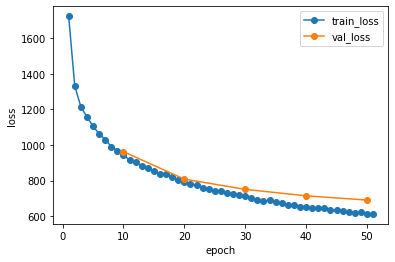

In [41]:
import matplotlib.pyplot as plt
 
#CSVファイルをUTF-8形式で読み込む
data = pd.read_csv('log_output.csv',encoding = 'UTF8')
#dataを出力
plt.plot(data['epoch'],data['train_loss'], marker='o', label='train_loss')
plt.plot(data['epoch'][9:50:10],data['val_loss'][9:50:10], marker='o',label="val_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()